# References:
    1) https://www.neuron.yale.edu/neuron/static/new_doc/programming/hocsyntax.html
    2) https://www.neuron.yale.edu/neuron/static/new_doc/programming/python.html
    3) https://www.neuron.yale.edu/neuron/static/py_doc/programming/python.html
    4) https://www.geeksforgeeks.org/single-neuron-neural-network-python/
    5) https://github.com/piazentin/ksets
    6) AP - https://www.moleculardevices.com/applications/patch-clamp-electrophysiology/what-action-potential#gref
    7) https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/network/netcon.html
    8) http://neupy.com/apidocs/neupy.algorithms.associative.hebb.html
    9) https://qbi-software.github.io/NEURON-tutorial/lessons/network
    10) https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/topology/geometry.html
    11) http://www.cnel.ufl.edu/courses/EEL6814/chapter6.pdf
    12) https://www.slideshare.net/mentelibre/hebbian-learning
    13) http://www.diva-portal.org/smash/get/diva2:1089220/FULLTEXT02

In [1]:
!pip install neuron

     |████████████████████████████████| 12.6 MB 183 kB/s 


### Stage 1: Import the required libraries

In [2]:
from neuron import h #.h is a HOC object instance & gui from neuron can also be imported 
from math import pi                  
from neuron.units import ms,mV
h.load_file('stdrun.hoc')                #Allows us to do a high level simulation

import random  
import matplotlib.pyplot as plt1

from bokeh.io import output_notebook
import bokeh.plotting as plt2
output_notebook()

import seaborn as sns

In [3]:
# FOR DEBUG
# See all methods and variables available for h
# import textwrap
# print(textwrap.fill(', '.join(dir(h))))

### Stage 2: Make a neuron with the specific properties

In [4]:
#This class makes one cell neuron(soma,axon,dendrite)
class MCELL:
    def __init__(self, gid, M):
        self._gid = gid #Neuron no.
        self.M = M+1
        #Setting morphology
        #Creating soma,dend and axon
        self.soma=h.Section(name='soma',cell=self)
        self.dend=h.Section(name='dend',cell=self)
        self.axon=h.Section(name='axon',cell=self)
#         self.axon2=h.Section(name='axon2',cell=self)
#         self.axon3=h.Section(name='axon3',cell=self)
        
        self.all = [self.axon, self.soma, self.dend] 
        #list of all the sections in the cell.
        #We could explicitly specify the connection location  by self.dend.connect(self.soma(0.5))
        
        self.dend.connect(self.soma,1,0)
        self.axon.connect(self.soma,0,0)
#         self.axon2.connect(self.soma,0,0)
#         self.axon3.connect(self.soma,0,0)
        
        # record all spike times in _spike_detector
        
        self._spike_detector = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)
        self.soma_v = h.Vector().record(self.soma(0.5)._ref_v)
        self._ncs = [] 
        
        #Defining geometry of soma
        self.soma.L = 18.8 
        self.soma.diam = 18.8 #in microns
        self.soma.nseg = 1                  #No. of segments
        
        #Defining geometry of dend
        self.dend.nseg = 1                  #No. of segments
        self.dend.L = 701.9                 #in microns
        self.dend.diam = 3.18                #in microns
        self.dendexcisyn = h.ExpSyn(self.dend(0.5))
        self.dendexcisyn.tau = 1 *ms
        self.dendexcisyn.e = 0 
        
        #Defining geometry for axon
        self.axon.nseg = 1
        self.axon.L = 152
        self.axon.diam = 3.18
        
        
#         self.axon2.nseg = 1
#         self.axon2.L = 152
#         self.axon2.diam = 3.18
        
#         self.axon3.nseg = 1
#         self.axon3.L = 152
#         self.axon3.diam = 3.18
        
        #Setting biophysics
        for sec in self.all:                                                  
            sec.Ra = 123    # Axial resistance in Ohm * cm                    
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        
        self.soma.insert('hh')            #Inserting HH neurons
        self.axon.insert('hh')
        self.dend.insert('pas')
#         self.axon2.insert('hh')
#         self.axon3.insert('hh')
        for seg in self.dend:                               
            seg.pas.g = 0.001  # Passive conductance in S/cm2 
            seg.pas.e = -78    # Leak reversal potential mV
        
    def __repr__(self):
        return 'Set [{}]_Mcell [{}]'.format(self.M,self._gid)
        #This shows how to represent each part when called upon

### Stage 3: Import random weights
We import the random weights as intitally the weights of the neurons are not adjusted to fire synchronously.

In [5]:
# wMM = random.uniform(1,3)
# wMML = random.uniform(1,3)

# s1= [4.6, 2.1]
# s2= [0.3, 0.4] 
# s3 = [wMM,wMML]

all_weights = [0.1,0.1]
print(all_weights)

[0.1, 0.1]


In [6]:
# Python3 generator for random integers that I tried once, not useful
# import math, random
# def give_curr():
#     yield abs(random.randint(-1,1))
    
# a = next(give_curr())
# print(a)

### Stage 4: Couple a neuron according to Freeman's KI Set with the weights generated above

In [7]:
#Gives one 2 coupled neuron using freeman's topology in olfactory bulb
class CONNECTING:
    """Coupling neurons
    """
    def __init__(self,M,weights,delay1=1,delay2=1):
        wMM=weights[0]
        
        self.M = M #Set no.
        self.th = -70
        self.maindelay = 0
        #self.syns = []
        #self.netcons = []
        
        #Making 2 neurons
        self.cells=[]
        self.M1=MCELL(1,self.M)
        self.M2=MCELL(2,self.M)
        self.cells.append(self.M1)
        self.cells.append(self.M2)

        # IClamp as defined here: https://www.neuron.yale.edu/neuron/static/py_doc/modelspec/programmatic/mechanisms/mech.html#IClamp 
        # Send a single pulse of current
        self.stim = h.IClamp(self.M1.dend(0.9))
        self.stim.delay = 1   #in ms
        self.stim.dur = 100     #in ms
        self.stim.amp = 0.8   #in nA
        
        #Connecting M1 to M2
        self.nc1 = h.NetCon(self.M1.soma(0.5)._ref_v,self.M2.dendexcisyn,sec=self.M1.soma)
        self.nc1.weight[0] = weights[0]
        self.nc1.delay = 0 #tm1m2
        self.nc1.threshold = self.th
        
        #Connecting M2 to M1
        self.nc2 = h.NetCon(self.M2.soma(0.5)._ref_v,self.M1.dendexcisyn,sec=self.M2.soma)
        self.nc2.weight[0] = weights[0]
        self.nc2.delay = 0 #tm2m1
        self.nc2.threshold = self.th
        
        

### Stage 5: Laterally connect each set of 2 coupled neurons according to Freeman's KI Set

In [8]:
class LATERAL:
    """Laterally coupling N-2 coupled neurons
    """
    def __init__(self,N,weights):
        wMML=weights[1]
        
        self.N = N
        self.th = -70
        self.maindelay = 20
        self.sets = []
        for i in range(N):
            self.sets.append(CONNECTING(i,weights))
        
        for r in range(1,N-1):
            for j in range(N-r-1):
                #Connecting M1[0] to M1[1]
                exec(f"self.nc11_{j} = h.NetCon(getattr(self.sets[j].M1.soma(0.5), '_ref_v'), self.sets[j+r].M1.dendexcisyn,sec=self.sets[j].M1.soma)")
                exec(f"self.nc11_{j}.weight[0] = wMML")
                exec(f"self.nc11_{j}.delay = self.maindelay")
                #exec(f"self.nc11_{j}.delay = 0")
                exec(f"self.nc11_{j}.threshold = self.th")
                exec(f"self.nc12_{j} = h.NetCon(getattr(self.sets[j+r].M1.soma(0.5), '_ref_v'), self.sets[j].M1.dendexcisyn,sec=self.sets[j+r].M1.soma)")
                exec(f"self.nc12_{j}.weight[0] = wMML")
                exec(f"self.nc12_{j}.delay = self.maindelay")
                #exec(f"self.nc12_{j}.delay = 0")
                exec(f"self.nc12_{j}.threshold = self.th")

### Stage 6: Input the number of 2 coupled sets required (which are all laterally connected)

In [9]:
#Give N value to get N no. of 2 coupled neurons laterally connected
#given_input_from_user = int(input('Enter the number of 2 coupled sets required: '))
given_input_from_user = 5
L1=LATERAL(given_input_from_user,all_weights)

### Stage 7: Visualize the topology of the neurons and the 3D space they are in. Also visualize the density mechanisms added to each neuron of a set.

In [10]:
# Basic Topology of the cell
h.topology()


|-|       Set [1]_Mcell [1].soma(0-1)
   `|       Set [1]_Mcell [1].dend(0-1)
 `|       Set [1]_Mcell [1].axon(0-1)
|-|       Set [1]_Mcell [2].soma(0-1)
   `|       Set [1]_Mcell [2].dend(0-1)
 `|       Set [1]_Mcell [2].axon(0-1)
|-|       Set [2]_Mcell [1].soma(0-1)
   `|       Set [2]_Mcell [1].dend(0-1)
 `|       Set [2]_Mcell [1].axon(0-1)
|-|       Set [2]_Mcell [2].soma(0-1)
   `|       Set [2]_Mcell [2].dend(0-1)
 `|       Set [2]_Mcell [2].axon(0-1)
|-|       Set [3]_Mcell [1].soma(0-1)
   `|       Set [3]_Mcell [1].dend(0-1)
 `|       Set [3]_Mcell [1].axon(0-1)
|-|       Set [3]_Mcell [2].soma(0-1)
   `|       Set [3]_Mcell [2].dend(0-1)
 `|       Set [3]_Mcell [2].axon(0-1)
|-|       Set [4]_Mcell [1].soma(0-1)
   `|       Set [4]_Mcell [1].dend(0-1)
 `|       Set [4]_Mcell [1].axon(0-1)
|-|       Set [4]_Mcell [2].soma(0-1)
   `|       Set [4]_Mcell [2].dend(0-1)
 `|       Set [4]_Mcell [2].axon(0-1)
|-|       Set [5]_Mcell [1].soma(0-1)
   `|       Set [5]_Mcell [1].den

1.0

In [11]:
# BUG: broken on colab, run in Jupyter Notebook for results
# this shows the actual neuron structure in a stick form
from neuron import h, gui2
gui2.set_backend('jupyter')
ps = gui2.PlotShape()
ps.variable('v')
ps.show(0)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
# For each section in all sections, print the type of neuron mechanism
for sec in h.allsec():
    print('%s: %s' % (sec, ', '.join(sec.psection()['density_mechs'].keys())))

Set [1]_Mcell [1].soma: hh
Set [1]_Mcell [1].dend: pas
Set [1]_Mcell [1].axon: hh
Set [1]_Mcell [2].soma: hh
Set [1]_Mcell [2].dend: pas
Set [1]_Mcell [2].axon: hh
Set [2]_Mcell [1].soma: hh
Set [2]_Mcell [1].dend: pas
Set [2]_Mcell [1].axon: hh
Set [2]_Mcell [2].soma: hh
Set [2]_Mcell [2].dend: pas
Set [2]_Mcell [2].axon: hh
Set [3]_Mcell [1].soma: hh
Set [3]_Mcell [1].dend: pas
Set [3]_Mcell [1].axon: hh
Set [3]_Mcell [2].soma: hh
Set [3]_Mcell [2].dend: pas
Set [3]_Mcell [2].axon: hh
Set [4]_Mcell [1].soma: hh
Set [4]_Mcell [1].dend: pas
Set [4]_Mcell [1].axon: hh
Set [4]_Mcell [2].soma: hh
Set [4]_Mcell [2].dend: pas
Set [4]_Mcell [2].axon: hh
Set [5]_Mcell [1].soma: hh
Set [5]_Mcell [1].dend: pas
Set [5]_Mcell [1].axon: hh
Set [5]_Mcell [2].soma: hh
Set [5]_Mcell [2].dend: pas
Set [5]_Mcell [2].axon: hh


### Plot Activation and Inactivation Parameters

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

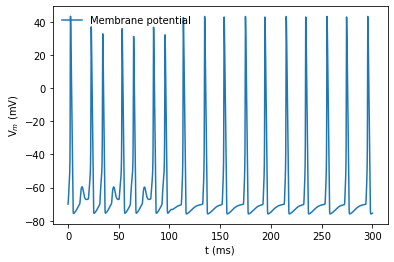

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

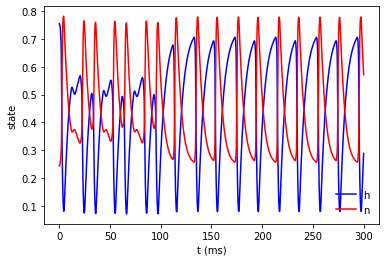

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

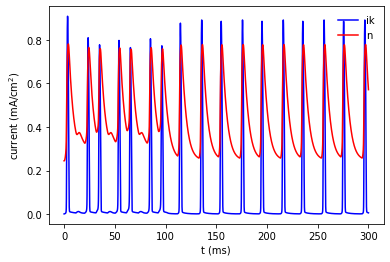

In [13]:
import numpy as np
from matplotlib import pyplot

# resource for all these parameters
# https://neuron.yale.edu/neuron/docs/hodgkin-huxley-using-rxd
# https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model#Voltage-gated_ion_channels

checkCell = L1.sets[0].M1.axon(0.5)

# Global time vector
tvec = h.Vector().record(h._ref_t)

# get Membrane Voltage
vvecA = h.Vector().record(checkCell._ref_v)
# k -> intracellular potassium concentration
kvecA = h.Vector().record(checkCell.k_ion._ref_ik)
# nvecA = h.Vector().record(checkCell.na_ion._ref_ina)
# m -> Sodium Channel activation
mvecA = h.Vector().record(checkCell.hh._ref_m)
# h -> Sodium Channel inactivation
hvecA = h.Vector().record(checkCell.hh._ref_h)
# n -> Potassium Channel activation
nvecA = h.Vector().record(checkCell.hh._ref_n)

# run for 300 ms
h.finitialize(-70)
h.continuerun(300)

# v vs t
fig = pyplot.figure()
pyplot.plot(tvec, vvecA, label="Membrane potential")
pyplot.xlabel('t (ms)')
pyplot.ylabel('V$_m$ (mV)')
pyplot.legend(frameon=False)

# plot sodium channel inactivation and potassium channel activation respectively
fig = pyplot.figure()
pyplot.plot(tvec, hvecA, '-b', label='h')
pyplot.plot(tvec, nvecA, '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('state')
pyplot.legend(frameon=False)


fig = pyplot.figure()

# intracellular potassium current and potassium channel activation
pyplot.plot(tvec, kvecA.as_numpy(), '-b', label='ik')
pyplot.plot(tvec, nvecA.as_numpy(), '-r', label='n')
pyplot.xlabel('t (ms)')
pyplot.ylabel('current (mA/cm$^2$)')
pyplot.legend(frameon=False)

        


No handles with labels found to put in legend.


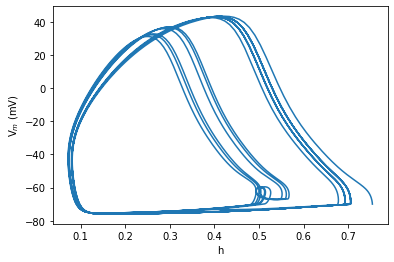

In [14]:
# Sodium Channel Activation vs voltage
import numpy as np
noise = np.random.normal(loc=0, scale=1, size=8001)

fig = pyplot.figure()
pyplot.plot(hvecA, vvecA, label="")
pyplot.xlabel('h')
pyplot.ylabel('V$_m$ (mV)')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


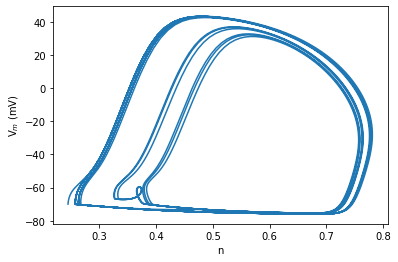

In [15]:
# Potassium Channel activation vs time
fig = pyplot.figure()
pyplot.plot(nvecA, vvecA, label="")
pyplot.xlabel('n')
pyplot.ylabel('V$_m$ (mV)')
pyplot.legend(frameon=False)

No handles with labels found to put in legend.


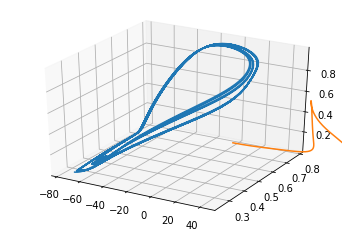

In [16]:
# Plot v,n,m,h in 4D plot
fig = pyplot.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(vvecA, nvecA, mvecA, hvecA)
# pyplot.xlabel('m')
# pyplot.ylabel('V$_m$ (mV)')
pyplot.legend(frameon=False)

### Stage 8: Record & visualize the voltage values at each axon of a neuron in the 1st set

In [17]:
recording_cell = L1.sets[0].M1
axon_m1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
dend_m1 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(200 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_m1), line_width=1,legend_label='P1 axon',line_color='black')
f.line(t, list(dend_m1), line_width=2,legend_label='P1 dendrite',line_color='red', line_dash='dashed')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
recording_cell = L1.sets[0].M2
axon_m2 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
dend_m2 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(-70 * mV)
h.continuerun(200 * ms)

f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
f.line(t, list(axon_m2), line_width=1,legend_label='P2 axon',line_color='black')
f.line(t, list(dend_m2), line_width=2,legend_label='P2 dendrite',line_color='red', line_dash='dashed')
plt2.show(f)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Stage 10: Visualize the spike timing of each neuron in a set

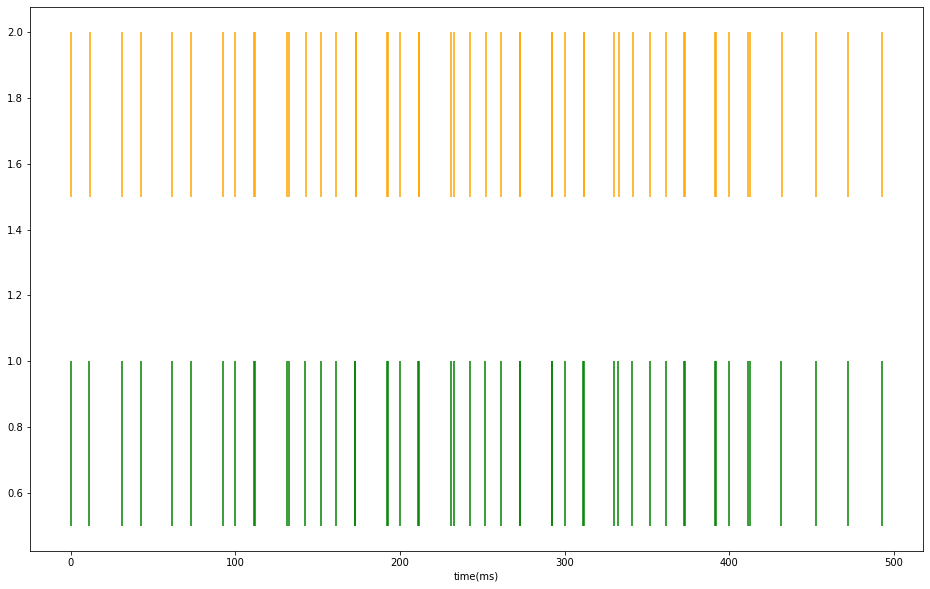

[0.025000000100000003, 11.200000000099898, 31.22500000009876, 42.45000000010109, 61.32500000010538, 72.82500000010799, 92.52500000011247, 111.67500000011682, 132.7250000001162, 151.90000000009877, 172.92500000007965, 192.1250000000622]
[0.025000000100000003, 11.200000000099898, 31.22500000009876, 42.45000000010109, 61.32500000010538, 72.82500000010799, 92.52500000011247, 111.67500000011682, 132.7250000001162, 151.90000000009877, 172.92500000007965, 192.1250000000622]


In [19]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(16,10))
for j in range(given_input_from_user):
    for i,cell in enumerate(L1.sets[j].cells):
        plt1.vlines(cell.spike_times+(100*j), i + 0.5, i + 1,color=color[i])
plt1.xlabel('time(ms)')
plt1.show()
t1=list(L1.sets[0].cells[0].spike_times)
t2=list(L1.sets[1].cells[0].spike_times)
print(t1)
print(t2)

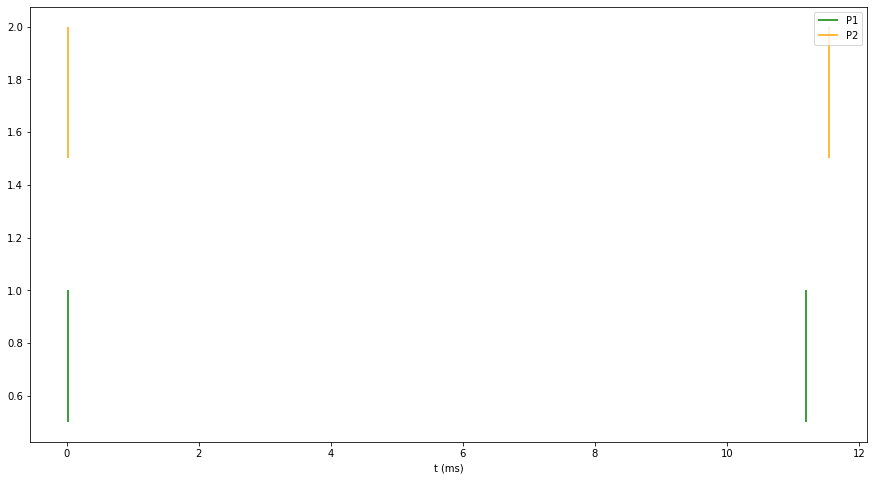

In [20]:
color=['green','orange']
label=['P1','P2']
plt1.figure(figsize=(15,8))
for i,cell in enumerate(L1.sets[j].cells):
    plt1.vlines(cell.spike_times, i + 0.5, i + 1,color=color[i],label=label[i])
plt1.xlabel('t (ms)')
plt1.legend()
plt1.show()

##### 